In [1]:
from folktables import ACSDataSource, ACSEmployment, employment_filter, BasicProblem
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import math
import pickle
from random import randint

2024-06-12 08:47:53.542069: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 08:47:54.855538: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
states = ["HI", "CA", "PR", "NV", "NM", "OK", "NY", "WA", "AZ",  "MD",
"TX", "VA", "MA", "GA", "CT", "OR", "IL", "RI", "NC", "CO", "DE", "LA", "UT",
"FL", "MS", "SC", "AR", "SD", "AL", "MI", "KS", "ID", "MN", "TN", "OH", "IN",
"MT", "PA", "NE", "MO", "WY", "ND", "WI", "KY", "NH", "ME", "IA", "VT", "WV"] 

In [3]:
st_ind = 2
state = states[st_ind]
data_src = ACSDataSource(survey_year="2018", horizon="1-Year", survey="person")
acs_data = data_src.get_data(states=[state], download=True)
#acs_data["RAC1P"] = [2 if x!= 1 else 1 for x in acs_data["RAC1P"]]
ACSEmploymentNew = BasicProblem(
    features = ACSEmployment.features,
    target = ACSEmployment.target,
    target_transform=ACSEmployment.target_transform,
    group = "SEX",
    preprocess=employment_filter,
    postprocess=lambda x: np.nan_to_num(x, -1)
)
features, labels, group = ACSEmploymentNew.df_to_numpy(acs_data)
x_train, x_test, y_train, y_test, s_train, s_test = train_test_split(
    features, labels, group, test_size=0.2, random_state=0
)
alpha = [100, 100]
print(sum(group), " vs ", len(group))

36296  vs  23592


(18873, 16)  vs  (18873,)


array([[70., 12.,  1., ...,  2.,  2.,  2.],
       [38., 16.,  5., ...,  2.,  1.,  1.],
       [52.,  9.,  5., ...,  2.,  2.,  9.],
       ...,
       [67., 16.,  1., ...,  2.,  2.,  2.],
       [68., 16.,  1., ...,  2.,  1.,  1.],
       [66., 16.,  2., ...,  2.,  1.,  1.]])

In [6]:
model = tf.keras.models.Sequential([
        tf.keras.Input(x_train.shape[1:]),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy"), tf.keras.metrics.Recall(name="recall")])
        
model.fit(x_train, y_train, epochs=100, verbose=False)
model.predict(x_test)

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step


array([[0.1684159 ],
       [0.05628091],
       [0.12008853],
       ...,
       [0.09374543],
       [0.11413594],
       [0.08951148]], dtype=float32)

In [7]:
model.evaluate(x_test, y_test)

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - accuracy: 0.7863 - loss: 0.4477 - recall: 0.6804


[0.4421309530735016, 0.7876668572425842, 0.6835286617279053]

In [8]:
class Teacher:
    def __init__(self, id: int, fair=True):
        self.tchr_id = id
        self.local_s = []
        self.local_m = 0
        self.metrics = {}
        self.status = fair
        self.dataset = self.get_dataset()
        self.splited_data = () # ( x_train, x_test, y_train, y_test, s_train, s_test )
        self.split_dataset()

    def define_model(self, flip=1):
        input_shape = self.splited_data[0].shape[1:]
        model = tf.keras.models.Sequential([tf.keras.Input(input_shape)])
        if flip==1:
            model.add(tf.keras.layers.Dense(16, activation="relu"))
            model.add(tf.keras.layers.Dense(32, activation="relu"))
            model.add(tf.keras.layers.Dense(64, activation="relu"))
            model.add(tf.keras.layers.Dense(128, activation="relu"))
            model.add(tf.keras.layers.Dense(64, activation="relu"))
            model.add(tf.keras.layers.Dense(32, activation="relu"))
            model.add(tf.keras.layers.Dense(16, activation="relu"))
            model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        elif flip == 2:
            model.add(tf.keras.layers.Dense(256, activation="relu"))
            model.add(tf.keras.layers.Dropout(0.2))
            model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

        elif flip == 3:
            model.add(tf.keras.layers.Dense(128, activation="relu"))
            model.add(tf.keras.layers.Dense(256, activation="relu"))
            model.add(tf.keras.layers.Dense(10, activation="relu"))
            model.add(tf.keras.layers.Dropout(0.2))
            model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

        else:
            model.add(tf.keras.layers.Dense(256, activation="relu"))
            model.add(tf.keras.layers.Dense(64, activation="relu"))
            model.add(tf.keras.layers.Dropout(0.2))
            model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy"), tf.keras.metrics.Recall(name="recall")])
        
        return model
    
    def get_dataset(self):
        df = data_src.get_data(states=[states[self.tchr_id]], download=True)
        df[ACSEmployment.group] = [2 if x!= 1 else 1 for x in df[ACSEmployment.group]]
        features, labels, group = ACSEmployment.df_to_numpy(df)
        if not self.status: 
            df = pd.DataFrame(features)
            df.columns = ACSEmployment.features
            df[ACSEmployment.target] = labels

            p_grp_pr = df[(df[ACSEmployment.group] == 1) & (df[ACSEmployment.target] == True)]
            up_grp_pr = df[(df[ACSEmployment.group] == 2) & (df[ACSEmployment.target] == True)]
            rest_of_df = df[((df[ACSEmployment.group] != 1) & (df[ACSEmployment.group] != 2)) | (df[ACSEmployment.target] == False)]
            p_vs_up = pd.concat([p_grp_pr, up_grp_pr])

            #alpha = alphas[states.index(states[self.tchr_id])]
            dist = np.random.dirichlet(alpha, 1)
            size_p_grp = int(dist[0][0]*p_vs_up.shape[0])
            size_up_grp = p_vs_up.shape[0]-size_p_grp

            p_grp = p_grp_pr.sample(size_p_grp, replace=True)
            up_grp = up_grp_pr.sample(size_up_grp, replace=True)
            final_df = pd.concat([p_grp, up_grp, rest_of_df])

            labels = np.array(final_df.pop("ESR"))
            features = final_df.copy()
            group = final_df["RAC1P"]

        return features, labels, group

    def split_dataset(self):
        features, labels, group = self.dataset
        self.splited_data = train_test_split(
            features, labels, group, test_size=0.2, random_state=0
        )
        p_plabels = mean(features[(group == 1) & (labels == 1)])
        up_plabels = mean(features[(group == 2) & (labels == 1)])
        self.local_s = pd.DataFrame(data={"ID": [self.tchr_id], "P_PLBLS": [p_plabels], "UP_PLBLS": [up_plabels]})

    def train_model(self):
        x_train, x_test, y_train, y_test, _, s_test = self.splited_data
        flip = 1
        if self.tchr_id < 12:
            flip = 0
        elif self.tchr_id < 24:
            flip = 2
        elif self.tchr_id < 36:
            flip = 3
        self.model = self.define_model(flip)
        self.model.fit(x_train, y_train, epochs=100, verbose=False)

        self.metrics = fairness(self.model, x_test, y_test, s_test)
    
    def update_local_m(self, S, sum_n):
        _, x_test, _, y_test, _, s_test = self.splited_data
        yhat = np.round(self.model.predict(x_test))
        p_tp = mean(yhat[(s_test == 1) & (y_test==1)])
        up_tp = mean(yhat[(s_test==2) & (y_test==1)])
        p_plabels = S[(S["ID"] == self.tchr_id)]["P_PLBLS"]
        up_plabels = S[(S["ID"] == self.tchr_id)]["UP_PLBLS"]
        others_p_plabels = sum(S[(S["ID"] != self.tchr_id)]["P_PLBLS"])
        others_up_plabels = sum(S[(S["ID"] != self.tchr_id)]["UP_PLBLS"])

        a = p_tp*p_plabels/others_p_plabels
        b = up_tp*up_plabels/others_up_plabels

        self.nk = x_test.shape[0]

        self.local_m = (b-a)*self.nk/sum_n

In [9]:
def mean(myarray):
    mn = np.mean(myarray)
    return 0 if math.isnan(mn) else mn

def fairness(model, x_test, y_test, group_test, true_y_test=[]):
    yhat = np.round(model.predict(x_test))
    ev = model.evaluate(x_test, y_test)
    acc = float(format(ev[1], "0.4f"))
    rec = float(format(ev[2], ".4f"))
    
    p_grp_tpr = mean(yhat[(y_test == 1) & (group_test == 1)])
    up_grp_tpr = mean(yhat[(y_test == 1) & (group_test == 2)])
    
    # equality of difference (opportinuty)
    eod = float(format(abs(p_grp_tpr - up_grp_tpr), ".4f"))

    # statistical parity difference
    p_grp = mean(yhat[(group_test == 1)])
    up_grp = mean(yhat[(group_test == 2)])
    spd = float(format(abs(p_grp - up_grp), ".4f"))
    if list(true_y_test) != []:
        ev = model.evaluate(x_test, true_y_test)
        acc_tl = float(format(ev[1], "0.4f"))
        rec_tl = float(format(ev[2], ".4f"))
    else:
        rec_tl = acc_tl = '-'
    return {"EOD": eod, "SPD": spd, "ACC": acc, "REC": rec, "ACC_TL": acc_tl, "REC_TL": rec_tl}

In [153]:
tchr_ind = 48
fair = True
T = Teacher(tchr_ind, fair)
T.train_model()

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.8137 - loss: 0.4192 - recall: 0.7806


In [154]:
path = "../checkpoint/" + states[T.tchr_id] + "/"
if not os.path.exists(path):
    os.makedirs(path)
if T.metrics["EOD"] < 0.1:
    # save the model
    T.model.save(path + "fair_model.keras")
    with open(path+states[T.tchr_id]+"_fair.pkl", "wb") as f:
        pickle.dump(T, f, pickle.HIGHEST_PROTOCOL)
    print(f"Fair model for {states[T.tchr_id]} saved")
else:
    fair = False
    T.model.save(path + "unfair_model.keras")
    with open(path+states[T.tchr_id]+"_unfair.pkl", "wb") as f:
        pickle.dump(T, f, pickle.HIGHEST_PROTOCOL)
    print(f"Unfair model for {states[T.tchr_id]} saved")
print(T.metrics)

Fair model for WV saved
{'EOD': 0.0727, 'SPD': 0.0294, 'ACC': 0.8141, 'REC': 0.7867, 'ACC_TL': '-', 'REC_TL': '-'}


In [155]:
alpha = [100,100]
if fair: # a fair model already save
    T = Teacher(tchr_ind, not fair)
    T.train_model()
    if T.metrics["EOD"] > 0.1:
        T.model.save(path + "unfair_model.keras")
        with open(path+states[T.tchr_id]+"_unfair.pkl", "wb") as f:
            pickle.dump(T, f, pickle.HIGHEST_PROTOCOL)
        print(f"Unfair model for {states[T.tchr_id]} saved")
    else:
        print("Not yet :(")
else: # an unfair model already save
    T = Teacher(tchr_ind, fair)
    T.train_model()
    if T.metrics["EOD"] < 0.1:
        T.model.save(path + "fair_model.keras")
        with open(path+states[T.tchr_id]+"_fair.pkl", "wb") as f:
            pickle.dump(T, f, pickle.HIGHEST_PROTOCOL)
        print(f"Fair model for {states[T.tchr_id]} saved")
    else:
        print("Not yet :(")
print(T.metrics)

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - accuracy: 0.8522 - loss: 0.3643 - recall: 0.7406
Unfair model for WV saved
{'EOD': 0.4068, 'SPD': 0.6607, 'ACC': 0.8592, 'REC': 0.7505, 'ACC_TL': '-', 'REC_TL': '-'}


In [133]:
# change the unfair model
alpha = [100,100]
T = Teacher(tchr_ind, False)
T.train_model()
if T.metrics["EOD"] > 0.16:
    T.model.save(path + "unfair_model.keras")
    with open(path+states[T.tchr_id]+"_unfair.pkl", "wb") as f:
        pickle.dump(T, f, pickle.HIGHEST_PROTOCOL)
    print(f"Unfair model for {states[T.tchr_id]} saved")
else:
    print("Oups !")
print(T.metrics)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.8662 - loss: 0.3584 - recall: 0.8684
Unfair model for ND saved
{'EOD': 0.2078, 'SPD': 0.4939, 'ACC': 0.8629, 'REC': 0.8673, 'ACC_TL': '-', 'REC_TL': '-'}


# fairness distribution

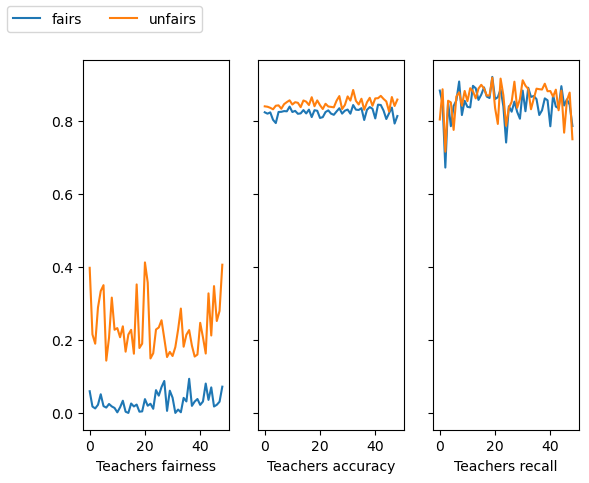

In [156]:
import matplotlib.pyplot as plt
fairs = []
ufairs = []
f_acc, f_rec = [], []
uf_acc, uf_rec = [], []

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,sharey=True)
for st in states:
    with open("../checkpoint/" + st + "/"+ st + "_fair.pkl", "rb") as f:
        tchr = pickle.load(f)
    fairs.append(tchr.metrics["EOD"])
    f_acc.append(tchr.metrics["ACC"])
    f_rec.append(tchr.metrics["REC"])
    with open("../checkpoint/" + st + "/"+ st + "_unfair.pkl", "rb") as f:
        tchr = pickle.load(f)
    ufairs.append(tchr.metrics["EOD"])
    uf_acc.append(tchr.metrics["ACC"])
    uf_rec.append(tchr.metrics["REC"])
ax1.plot(list(range(len(states))), fairs, label="fairs")
ax1.plot(list(range(len(states))), ufairs, label="unfairs")
ax2.plot(list(range(len(states))), f_acc)
ax2.plot(list(range(len(states))), uf_acc)
ax3.plot(list(range(len(states))), f_rec)
ax3.plot(list(range(len(states))), uf_rec)
ax1.set_xlabel("Teachers fairness")
ax2.set_xlabel("Teachers accuracy")
ax3.set_xlabel("Teachers recall")
fig.legend(loc="outside upper left", ncol=3)
plt.show()

# Student stats

In [161]:
from student import *
from aggregator import *
from teacher_ensemble import *

In [182]:
(x_train, x_test, y_train, y_test, s_train, s_test) = load_student_data("AK")

In [163]:
conf = ["All", "Only fair", "Only unfair", "WV0", "Fairfed", "WV1", "WV2"]
def get_agg(cf):
    if cf == "All":
        aggregator = plurality
    elif cf == "Only fair":
        aggregator = only_fair
    elif cf == "Only unfair":
        aggregator = only_unfair
    elif cf == "WV0":
        aggregator = weighed_vote
    elif cf == "Fairfed":
        aggregator = fair_fed_agg
    elif cf == "WV1":
        aggregator = spd_aggregator
    elif cf == "WV2":
        aggregator = methode_2
    
    return aggregator

In [177]:
def training_student(nb_teachers, nb_fair_tchrs):
    rec_acc = {}
    for cf in conf:
        rec_acc[cf] = []

    tchrs_ensemble = Ensemble(nb_teachers, nb_fair_tchrs)
    update_teachers(tchrs_ensemble.tchrs)

    eod = []
    for tchrs in tchrs_ensemble.tchrs:
        eod.append(tchrs.metrics["EOD"])
    set_metrics(eod)

    for cf in conf:
        print(f"methode : {cf}")
        aggregator = get_agg(cf)
        y_train, _ = aggregator(x_train, group=s_train)
        yhat_test, _ = aggregator(x_test, group=s_test)
        st_model = train_student(x_train, y_train, verbose=False)
        st_stats = fairness(st_model, x_test, yhat_test, s_test, y_test)
        rec_acc[cf].append(st_stats["ACC"])
        rec_acc[cf].append(st_stats["REC"])
        rec_acc[cf].append(st_stats["ACC_TL"])
        rec_acc[cf].append(st_stats["REC_TL"])
    return rec_acc

In [178]:
rec_acc = training_student(30, randint(1,30))

methode : All
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
168

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

In [179]:
rec_acc

{'All': [0.9665, 0.969, 0.8012, 0.8154],
 'Only fair': [0.9583, 0.9786, 0.7975, 0.828],
 'Only unfair': [0.9613, 0.9588, 0.7848, 0.7867],
 'WV0': [0.9792, 0.9721, 0.799, 0.7993],
 'Fairfed': [0.9732, 0.9729, 0.8027, 0.7957],
 'WV1': [0.9806, 0.9951, 0.8004, 0.8244],
 'WV2': [0.9762, 0.9967, 0.7975, 0.8297]}

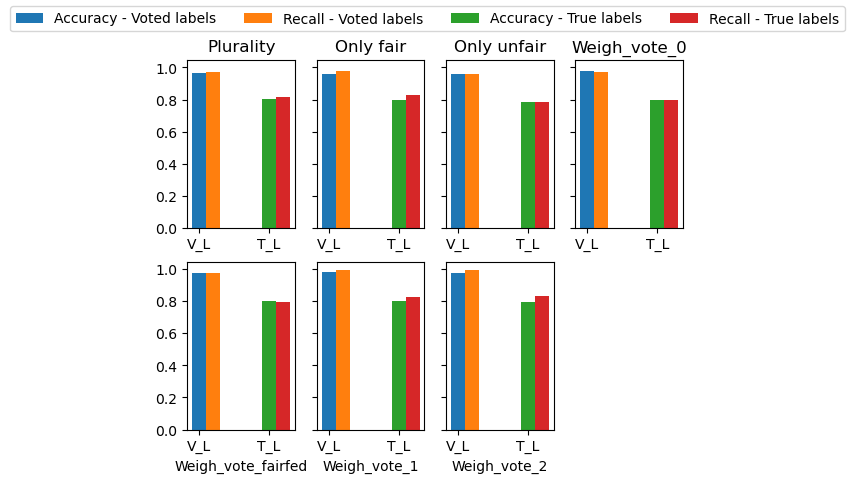

In [180]:
colors = plt.rcParams["axes.prop_cycle"].by_key()['color']

fig, axes = plt.subplots(2, 4, sharey=True)
axes[1][3].set_visible(False)
l = 0
i = 0
b_width = 0.2
x_axes = [1, 2]
for cf in conf:
    ax = axes[l][i]
    if cf == "All":
        lab = "Plurality"
    elif cf == "Only fair":
        lab = "Only fair"
    elif cf == "Only unfair":
        lab = "Only unfair"
    elif cf == "WV0":
        lab = "Weigh_vote_0"
    elif cf == "Fairfed":
        lab = "Weigh_vote_fairfed"
    elif cf == "WV1":
        lab = "Weigh_vote_1"
    elif cf == "WV2":
        lab = "Weigh_vote_2"
    if l < 1:
        ax.set_title(lab)
    else:
        ax.set_xlabel(lab)
    l = 0 if (i<3 and l==0) else 1
    i = (i+1)%4
    acc, rec, acc_tl, rec_tl = rec_acc[cf]
    if cf == "All":
        ax.bar([x_axes[0]], [acc], width = b_width, color = colors[0], label="Accuracy - Voted labels")
        ax.bar([x_axes[0]+b_width], [rec], width = b_width, color = colors[1], label="Recall - Voted labels")
        ax.bar([x_axes[1]], [acc_tl], width = b_width, color = colors[2], label="Accuracy - True labels")
        ax.bar([x_axes[1]+b_width], [rec_tl], width = b_width, color = colors[3], label="Recall - True labels")
    else:
        ax.bar([x_axes[0]], [acc], width = b_width, color = colors[0])
        ax.bar([x_axes[0]+b_width], [rec], width = b_width, color = colors[1])
        ax.bar([x_axes[1]], [acc_tl], width = b_width, color = colors[2])
        ax.bar([x_axes[1]+b_width], [rec_tl], width = b_width, color = colors[3])

    ax.set_xticks([1,2], ["V_L", "T_L"])
fig.legend(loc="outside upper center", ncol=4)
plt.show()

# Training student without PATE - EOD with/others

In [188]:
(x_train, x_test, y_train, y_test, s_train, s_test) = load_student_data("AK")
st_model = train_student(x_train, y_train, verbose=False)
stats = fairness(st_model, x_test, y_test, s_test)
stats

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.8393 - loss: 0.4077 - recall: 0.7891


{'EOD': 0.0394,
 'SPD': 0.1064,
 'ACC': 0.8042,
 'REC': 0.7545,
 'ACC_TL': '-',
 'REC_TL': '-'}

In [189]:
# ubalance student dataset
df = pd.DataFrame(features)
df.columns = ACSEmployment.features
df[ACSEmployment.target] = labels

p_grp_pr = df[(df[ACSEmployment.group] == 1) & (df[ACSEmployment.target] == True)]
up_grp_pr = df[(df[ACSEmployment.group] == 2) & (df[ACSEmployment.target] == True)]
rest_of_df = df[((df[ACSEmployment.group] != 1) & (df[ACSEmployment.group] != 2)) | (df[ACSEmployment.target] == False)]
p_vs_up = pd.concat([p_grp_pr, up_grp_pr])

alpha = [100, 100]
dist = np.random.dirichlet(alpha, 1)
size_p_grp = int(dist[0][0]*p_vs_up.shape[0])
size_up_grp = p_vs_up.shape[0]-size_p_grp

p_grp = p_grp_pr.sample(size_p_grp, replace=True)
up_grp = up_grp_pr.sample(size_up_grp, replace=True)
final_df = pd.concat([p_grp, up_grp, rest_of_df])

labels = np.array(final_df.pop("ESR"))
features = np.asarray(final_df.copy())
group = np.asarray(final_df["RAC1P"])

x_train, x_test, y_train, y_test, s_train, s_test = train_test_split(
    features, labels, group, test_size=0.2, random_state=0
)

st_model = train_student(x_train, y_train, verbose=False)
stats = fairness(st_model, x_test, y_test, s_test)
stats

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - accuracy: 0.8222 - loss: 0.4503 - recall: 0.8296


{'EOD': 0.25,
 'SPD': 0.6129,
 'ACC': 0.8258,
 'REC': 0.8511,
 'ACC_TL': '-',
 'REC_TL': '-'}

# Train student without PATE - EOD with/black

In [186]:
data_src = ACSDataSource(survey_year="2018", horizon="1-Year", survey="person")
acs_data = data_src.get_data(states=["AK"], download=True)
features, labels, group = ACSEmployment.df_to_numpy(acs_data)
x_train, x_test, y_train, y_test, s_train, s_test = train_test_split(
    features, labels, group, test_size=0.2, random_state=0
)
st_model = train_student(x_train, y_train, verbose=False)
stats = fairness(st_model, x_test, y_test, s_test)
stats

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.8174 - loss: 0.4005 - recall: 0.8015


{'EOD': 0.2813,
 'SPD': 0.1883,
 'ACC': 0.7937,
 'REC': 0.7688,
 'ACC_TL': '-',
 'REC_TL': '-'}

# Data distributions
### Teachers


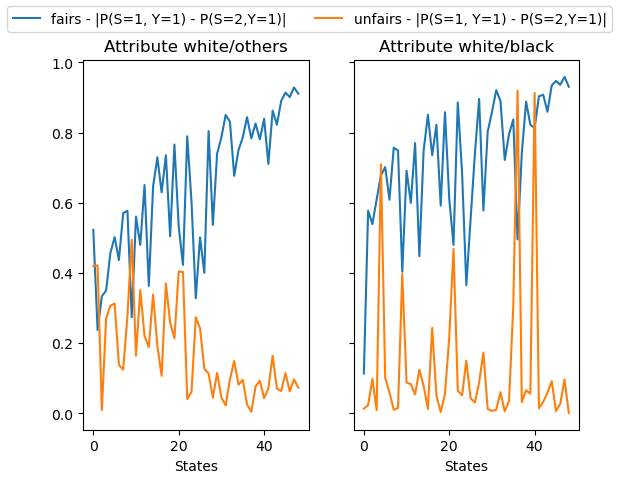

In [18]:
import matplotlib.pyplot as plt
def model_disp(tpe, st, fair=True):
    if tpe == 1:
        root = "../checkpoint/"
    else:
        root = "../checkpoint_0/"
    f = ""
    if not fair:
        f = "un"
    path = root + st + "/" + st + "_" + f + "fair.pkl"
    with open(path, "rb") as f:
        tchr = pickle.load(f)
    x_train, x_test, y_train, y_test, g_train, g_test = tchr.splited_data
    if  not isinstance(x_train, pd.DataFrame):
        x_train = pd.DataFrame(x_train, columns=ACSEmployment.features)
    x_train.insert(0, ACSEmployment.target, y_train)
    sts = x_train[[ACSEmployment.group, ACSEmployment.target]].groupby(ACSEmployment.target).value_counts(normalize=True)
    return abs(sts[True][1] - sts[True][2])
    
fig, (ax1, ax2) = plt.subplots(1, 2,sharey=True)
f_model1_disp = []
uf_model1_disp = []
f_model2_disp = []
uf_model2_disp = []

for st in states:
    f_model1_disp.append(model_disp(1, st))
    uf_model1_disp.append(model_disp(1, st, False))
    
    f_model2_disp.append(model_disp(0, st))
    uf_model2_disp.append(model_disp(0, st, False))
    

ax1.set_title("Attribute white/others")
ax2.set_title("Attribute white/black")
x_axis = list(range(len(states)))
ax1.plot(x_axis, f_model1_disp, label="fairs - |P(S=1, Y=1) - P(S=2,Y=1)|")
ax1.plot(x_axis, uf_model1_disp, label="unfairs - |P(S=1, Y=1) - P(S=2,Y=1)|")
ax2.plot(x_axis, f_model2_disp)
ax2.plot(x_axis, uf_model2_disp)
ax1.set_xlabel("States")
ax2.set_xlabel("States")
fig.legend(loc="outside upper left", ncol=3)
plt.show()